In [1]:
## USE for Multi GPU Systems
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0"

from keras.models import Sequential, load_model
from keras.layers import *
from keras import optimizers
from keras import utils
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import keras

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

import tensorflow as tf

# Importing matplotlib to plot images.
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Importing SK-learn to calculate precision and recall
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneGroupOut
from sklearn.utils import shuffle 

# Used for graph export
from keras import backend as K

Using TensorFlow backend.


In [2]:
class LoggingTensorBoard(TensorBoard):    

    def __init__(self, log_dir, settings_str_to_log, **kwargs):
        super(LoggingTensorBoard, self).__init__(log_dir, **kwargs)

        self.settings_str = settings_str_to_log

    def on_train_begin(self, logs=None):
        TensorBoard.on_train_begin(self, logs=logs)

        tensor =  tf.convert_to_tensor(self.settings_str)
        summary = tf.summary.text ("Run_Settings", tensor)

        with  tf.Session() as sess:
            s = sess.run(summary)
            self.writer.add_summary(s)

In [3]:
dfAll = pd.read_pickle("DataStudyCollection/df_lstm_norm50.pkl")

lst = dfAll.userID.unique()
np.random.seed(42)
np.random.shuffle(lst)
test_ids = lst[-5:]
train_ids = lst[:-5]
print(train_ids, test_ids)

[ 1  2  9  6  4 14 17 16 12  3 10 18  5] [13  8 11 15  7]


In [4]:
dfAll.userID.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18])

In [5]:
dfAll.TaskID = dfAll.TaskID % 17

In [6]:
df_train = dfAll[dfAll.userID.isin(train_ids)][['Blobs', 'TaskID']]
df_test = dfAll[dfAll.userID.isin(test_ids)][['Blobs', 'TaskID']]

In [7]:
x_train = np.concatenate(df_train.Blobs.values).reshape(-1,50,27,15,1)
x_test = np.concatenate(df_test.Blobs.values).reshape(-1,50,27,15,1)

y_train = df_train.TaskID.values
y_test = df_test.TaskID.values

x_train = x_train / 255.0
x_test = x_test / 255.0

# convert class vectors to binary class matrices (one-hot notation)
num_classes = len(dfAll.TaskID.unique())
y_train_one_hot = utils.to_categorical(df_train.TaskID, num_classes)
y_test_one_hot = utils.to_categorical(df_test.TaskID, num_classes)

In [8]:
# If GPU is not available: 
# GPU_USE = '/cpu:0'
#config = tf.ConfigProto(device_count = {"GPU": 1})


# If GPU is available: 
config = tf.ConfigProto()
config.log_device_placement = True
config.allow_soft_placement = True
config.gpu_options.allow_growth=True
config.gpu_options.allocator_type = 'BFC'

# Limit the maximum memory used
config.gpu_options.per_process_gpu_memory_fraction = 0.3

# set session config
tf.keras.backend.set_session(tf.Session(config=config))

In [10]:
batch_size = 50
epochs = 3000
timesteps = 50
data_dim = (27,15)
l1v = 0.005
l2v = 0.015


tf.get_default_graph()
model = Sequential()

model.add(TimeDistributed(Conv2D(64, kernel_size=(3,3), activation='relu', 
                                padding='same', kernel_regularizer=regularizers.l1_l2(l1v,l2v)),
                                input_shape=(timesteps ,27, 15, 1)))
model.add(TimeDistributed(Conv2D(32, kernel_size=(3, 3), activation='relu',
                                 padding='same', kernel_regularizer=regularizers.l1_l2(l1v,l2v))))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=None,
                                       padding='same', data_format='channels_last')))
model.add(TimeDistributed(Dropout(0.50)))

model.add(TimeDistributed(Conv2D(32, kernel_size=(3, 3), activation='relu',
                                 padding='same', kernel_regularizer=regularizers.l1_l2(l1v,l2v))))
model.add(TimeDistributed(Conv2D(16, kernel_size=(3, 3), activation='relu',
                                 padding='same', kernel_regularizer=regularizers.l1_l2(l1v,l2v))))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=None, padding='same', data_format='channels_last')))
model.add(TimeDistributed(Dropout(0.50)))

model.add(TimeDistributed(Flatten()))

model.add(keras.layers.LSTM(80, return_sequences=True, input_shape=(timesteps, data_dim), kernel_regularizer=regularizers.l1_l2(l1v,l2v)))
model.add(Dropout(0.5))

model.add(keras.layers.LSTM(50, return_sequences=False, input_shape=(timesteps, data_dim), kernel_regularizer=regularizers.l1_l2(l1v,l2v)))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

#optimizer = optimizers.Adagrad()
optimizer = optimizers.Adam(lr = 0.0001, decay=1e-6)
#optimizer = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.1)
model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

model.load_weights('./ModelSnapshots/LSTM-v1_DONE.h5')
                  
#Broadcast progress to the tensorboard.

config = ""
for layer in model.layers:
    config += str(layer.output).split('\"')[1].split("/")[0] + str(layer.output_shape) + "\n\n"
config += "batchsize: " + str(batch_size) + "\n\n" + "epochs: " + str(epochs) + "\n\n" 
config += "l1: " + str(l1v) + "\n\n" + "l2: " + str(l2v) + "\n\n"

model.summary()
current_name = "LSTM_v2"
readable_timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d_%H%M%S')
tensorflowfolder = "/srv/share/tensorboardfiles/" + current_name 
print(current_name + readable_timestamp)
logger = LoggingTensorBoard(settings_str_to_log = config, log_dir=tensorflowfolder, histogram_freq=0,
                            write_graph=True, write_images=True, update_freq = 'epoch')

storer = ModelCheckpoint("./ModelSnapshots/" + current_name + readable_timestamp + '-{epoch:03d}.h5',
                         monitor='val_acc', verbose=1,
                         save_best_only=True, save_weights_only=False,
                         mode='auto', period=1)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=30, 
                                            verbose=1, 
                                            factor=0.95, 
                                            min_lr=0.00001)

history = model.fit(x_train, y_train_one_hot,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=2,
                        validation_data=(x_test, y_test_one_hot),
                        callbacks=[storer,logger, learning_rate_reduction])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_10 (TimeDis (None, 50, 27, 15, 64)    640       
_________________________________________________________________
time_distributed_11 (TimeDis (None, 50, 27, 15, 32)    18464     
_________________________________________________________________
time_distributed_12 (TimeDis (None, 50, 14, 8, 32)     0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, 50, 14, 8, 32)     0         
_________________________________________________________________
time_distributed_14 (TimeDis (None, 50, 14, 8, 32)     9248      
_________________________________________________________________
time_distributed_15 (TimeDis (None, 50, 14, 8, 16)     4624      
_________________________________________________________________
time_distributed_16 (TimeDis (None, 50, 7, 4, 16)      0         
__________

In [11]:
model.save("./ModelSnapshots/" + current_name + "_DONE.h5")

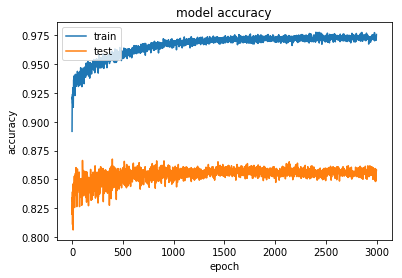

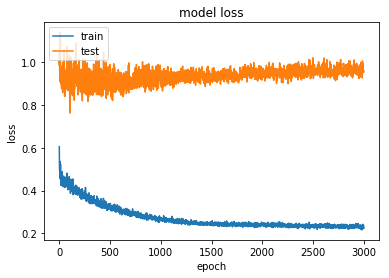

In [12]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()